<a href="https://colab.research.google.com/github/660710078/TopGun2025/blob/main/Drone_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics opencv-python-headless pillow PyYAML

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.3 MB/s eta 0:00:00


In [ ]:
import os
from ultralytics import YOLO
import cv2
from IPython.display import Image, display
import yaml
import matplotlib.pyplot as plt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = '/content/drive/MyDrive/drone_dataset'
yaml_path = f'{base_path}/data.yaml'

# check if path exist
if not os.path.exists(base_path):
    print(f"dataset not found at {base_path}")
else:
    print(f"dataset found at {base_path}")

if os.path.exists(yaml_path):
    print("data.yaml alredy exist\n")

    with open(yaml_path, 'r') as f:
        yaml_content = yaml.safe_load(f)
        print(yaml.dump(yaml_content, sort_keys=False, default_flow_style=False))

dataset found at /content/drive/MyDrive/drone_dataset
data.yaml alredy exist

path: /content/drive/MyDrive/drone_dataset
train: train/images
val: valid/images
nc: 1
names:
  0: drone
roboflow:
  workspace: tracker-qjlj1
  project: drones_new
  version: 4
  license: CC BY 4.0
  url: https://universe.roboflow.com/tracker-qjlj1/drones_new/dataset/4



In [ ]:
def check_dataset_structure(base_path):
    """
    ตรวจสอบโครงสร้าง dataset และนับจำนวนไฟล์
    """
    splits = ['train', 'valid']
    summary = {}

    for split in splits:
        img_dir = f'{base_path}/{split}/images'
        lbl_dir = f'{base_path}/{split}/labels'

        # check if folder exist
        if not os.path.exists(img_dir):
            print(f"Folder not founded: {img_dir}")
            continue
        if not os.path.exists(lbl_dir):
            print(f"Folder not founded: {lbl_dir}")
            continue

        # count files
        images = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        labels = [f for f in os.listdir(lbl_dir) if f.endswith('.txt')]

        num_images = len(images)
        num_labels = len(labels)

        summary[split] = {
            'images': num_images,
            'labels': num_labels,
            'match': num_images == num_labels
        }

        print(f"   Images: {num_images}")
        print(f"   Labels: {num_labels}")
        print(f"   Match: {'Yes' if num_images == num_labels else 'No'}")

    total_images = sum(s['images'] for s in summary.values())
    total_labels = sum(s['labels'] for s in summary.values())

    print("\n" + "="*60)
    print(f"summary:")
    print(f"   images count: {total_images}")
    print(f"   Labels count: {total_labels}")
    print("="*60 + "\n")

    return summary

In [ ]:
dataset_summary = check_dataset_structure(base_path)

   Images: 1012
   Labels: 1012
   Match: Yes
   Images: 347
   Labels: 348
   Match: No

summary:
   images count: 1359
   Labels count: 1360



In [ ]:
def visualize_sample(base_path, split='train', num_samples=3):
    """
    แสดงตัวอย่างรูปภาพพร้อม bounding box
    """
    img_dir = f'{base_path}/{split}/images'
    lbl_dir = f'{base_path}/{split}/labels'

    image_files = [f for f in os.listdir(img_dir)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:num_samples]

    print(f"\n Datset example ({split} set):\n")

    fig, axes = plt.subplots(1, min(num_samples, 3), figsize=(15, 5))
    if num_samples == 1:
        axes = [axes]

    for idx, img_file in enumerate(image_files):
        # read pic
        img_path = os.path.join(img_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        # read label
        lbl_path = os.path.join(lbl_dir, os.path.splitext(img_file)[0] + '.txt')

        if os.path.exists(lbl_path):
            with open(lbl_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        cls, x_center, y_center, width, height = map(float, parts)

                        # Convert to real พิกัด
                        x1 = int((x_center - width/2) * w)
                        y1 = int((y_center - height/2) * h)
                        x2 = int((x_center + width/2) * w)
                        y2 = int((y_center + height/2) * h)

                        # draw bounding box
                        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                        cv2.circle(img, (int(x_center*w), int(y_center*h)), 5, (0, 255, 0), -1)

        # show img
        if idx < len(axes):
            axes[idx].imshow(img)
            axes[idx].set_title(img_file, fontsize=10)
            axes[idx].axis('off')

    plt.tight_layout()
    plt.show()


 Datset example (train set):



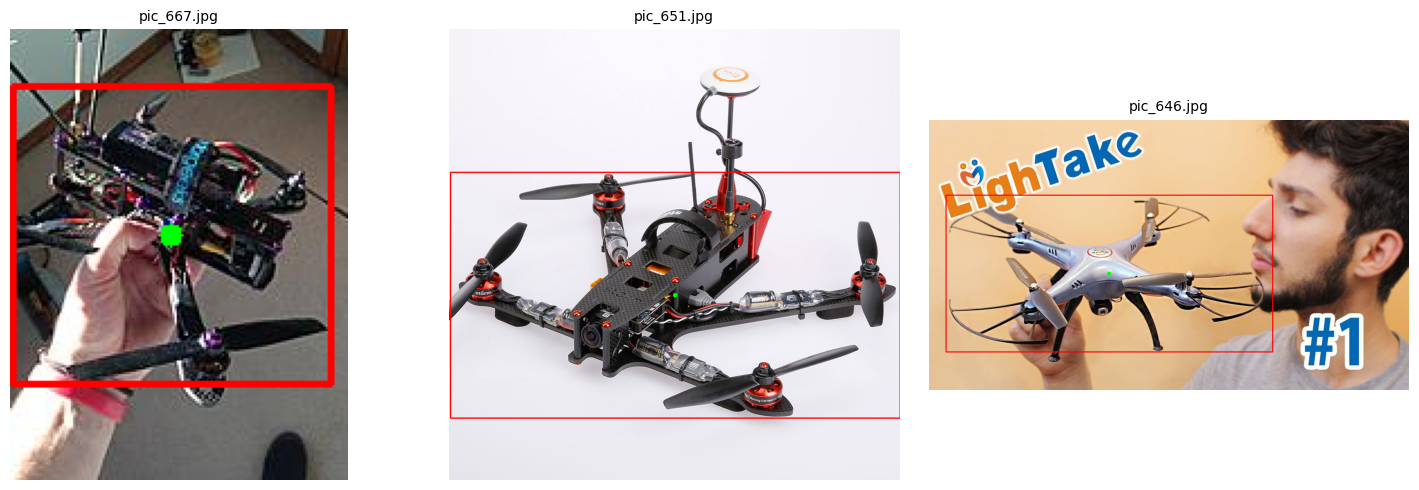

In [ ]:
visualize_sample(base_path, 'train', num_samples=3)

In [ ]:
model = YOLO('yolov8n.pt')

In [ ]:
results = model.train(
    data=yaml_path,              # path ไปยัง data.yaml
    epochs=50,                   # จำนวน epochs
    imgsz=640,                   # ขนาดรูปภาพ 640*640
    batch=16,                    # batch size

    # Training settings
    patience=20,                 # early stopping patience
    save=True,                   # บันทึก checkpoints
    save_period=10,              # บันทึกทุก N epochs
    cache=False,                 # cache images (True=เร็วขึ้นแต่ใช้ RAM มาก)

    # Optimization
    optimizer='auto',            # optimizer: SGD, Adam, AdamW, auto
    lr0=0.01,                    # initial learning rate
    lrf=0.01,                    # final learning rate (lr0 * lrf)
    momentum=0.937,              # SGD momentum
    weight_decay=0.0005,         # optimizer weight decay

    # Project settings
    project='drone_detection',   # ชื่อโปรเจค
    name='exp',                  # ชื่อ experiment
    exist_ok=True,               # อนุญาตให้เขียนทับ

    # Logging
    verbose=True,                # แสดงรายละเอียด

    # Augmentation
    # hsv_h=0.015,                # HSV-Hue augmentation
    # hsv_s=0.7,                  # HSV-Saturation
    # hsv_v=0.4,                  # HSV-Value
    # degrees=10.0,               # rotation (+/- degrees)
    # translate=0.1,              # translation (+/- fraction)
    # scale=0.5,                  # scaling (+/- gain)
    # shear=0.0,                  # shear (+/- degrees)
    # perspective=0.0,            # perspective (+/- fraction)
    # flipud=0.0,                 # flip up-down probability
    # fliplr=0.5,                 # flip left-right probability
    # mosaic=1.0,                 # mosaic augmentation probability
    # mixup=0.0,                  # mixup augmentation probability
    # copy_paste=0.0,             # copy-paste augmentation probability
)

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/drone_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plot

In [ ]:
best_model_path = 'drone_detection/exp/weights/best.pt'
model = YOLO(best_model_path)

In [ ]:
val_metrics = model.val(data=yaml_path, split='val')

print(f"   mAP50:     {val_metrics.box.map50:.4f}")
print(f"   mAP50-95:  {val_metrics.box.map:.4f}")
print(f"   Precision: {val_metrics.box.mp:.4f}")
print(f"   Recall:    {val_metrics.box.mr:.4f}")

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.2 ms, read: 48.5±36.1 MB/s, size: 99.9 KB)
val: Scanning /content/drive/MyDrive/drone_dataset/valid/labels.cache... 347 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 347/347 502.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 22/22 2.5it/s 8.9s
                   all        347        369      0.936      0.856       0.93      0.569
Speed: 1.9ms preprocess, 5.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to /content/runs/detect/val
   mAP50:     0.9302
   mAP50-95:  0.5690
   Precision: 0.9363
   Recall:    0.8564


In [ ]:
def detect_drones_image(image_path, save_path='result.jpg', conf=0.5, iou=0.45):
    """
    ตรวจจับ drone ในรูปภาพเดียว

    Args:
        image_path: path ของรูปภาพ
        save_path: path สำหรับบันทึกผลลัพธ์
        conf: confidence threshold (0-1)
        iou: IoU threshold for NMS

    Returns:
        num_drones: จำนวน drone
        drone_info: ข้อมูล drone แต่ละตัว
    """
    # Predict
    results = model.predict(
        source=image_path,
        conf=conf,
        iou=iou,
        save=False,
        verbose=False
    )

    # draw bounding box
    annotated = results[0].plot()

    # ดึงข้อมูล bounding boxes
    boxes = results[0].boxes
    num_drones = len(boxes)

    drone_info = []

    for i, box in enumerate(boxes):
        # พิกัด (xyxy format)
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()

        # center
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2

        # conf
        confidence = box.conf[0].cpu().numpy()

        # Class (drone = 0)
        cls = int(box.cls[0].cpu().numpy())

        # เก็บข้อมูล
        drone_info.append({
            'id': i + 1,
            'class': cls,
            'center': (int(center_x), int(center_y)),
            'bbox': (int(x1), int(y1), int(x2), int(y2)),
            'confidence': float(confidence),
            'width': int(x2 - x1),
            'height': int(y2 - y1),
            'area': int((x2 - x1) * (y2 - y1))
        })

        # draw center
        cv2.circle(annotated, (int(center_x), int(center_y)), 8, (0, 255, 0), -1)
        cv2.circle(annotated, (int(center_x), int(center_y)), 10, (0, 0, 255), 2)

        # add text
        text = f"Drone #{i+1}"
        cv2.putText(annotated, text, (int(center_x)+15, int(center_y)-15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        # พิกัดจุดกึ่งกลาง
        coord_text = f"({int(center_x)}, {int(center_y)})"
        cv2.putText(annotated, coord_text, (int(center_x)+15, int(center_y)+10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        # Confidence
        conf_text = f"{confidence:.2%}"
        cv2.putText(annotated, conf_text, (int(x1), int(y1)-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

    # ใส่สรุปที่มุมบนซ้าย
    summary_text = f"Drones Detected: {num_drones}"
    cv2.rectangle(annotated, (5, 5), (400, 50), (0, 0, 0), -1)
    cv2.putText(annotated, summary_text, (10, 35),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

    # บันทึก
    cv2.imwrite(save_path, annotated)

    # แสดงผล
    print(f"\n{'='*60}")
    print(f"Detection result: {os.path.basename(image_path)}")
    print(f"{'='*60}")
    print(f"Founded drone: {num_drones}\n")

    for info in drone_info:
        print(f"Drone #{info['id']}:")
        print(f"  └─ centroid: {info['center']}")
        print(f"  └─ Bounding Box: {info['bbox']}")
        print(f"  └─ size: {info['width']} x {info['height']} px")
        print(f"  └─ area: {info['area']} px²")
        print(f"  └─ Conf: {info['confidence']:.2%}\n")

    # แสดงใน Colab
    display(Image(filename=save_path))

    return num_drones, drone_info


Detection result: foto05656.jpg
Founded drone: 1

Drone #1:
  └─ centroid: (593, 242)
  └─ Bounding Box: (415, 115, 771, 368)
  └─ size: 356 x 252 px
  └─ area: 90041 px²
  └─ Conf: 83.81%



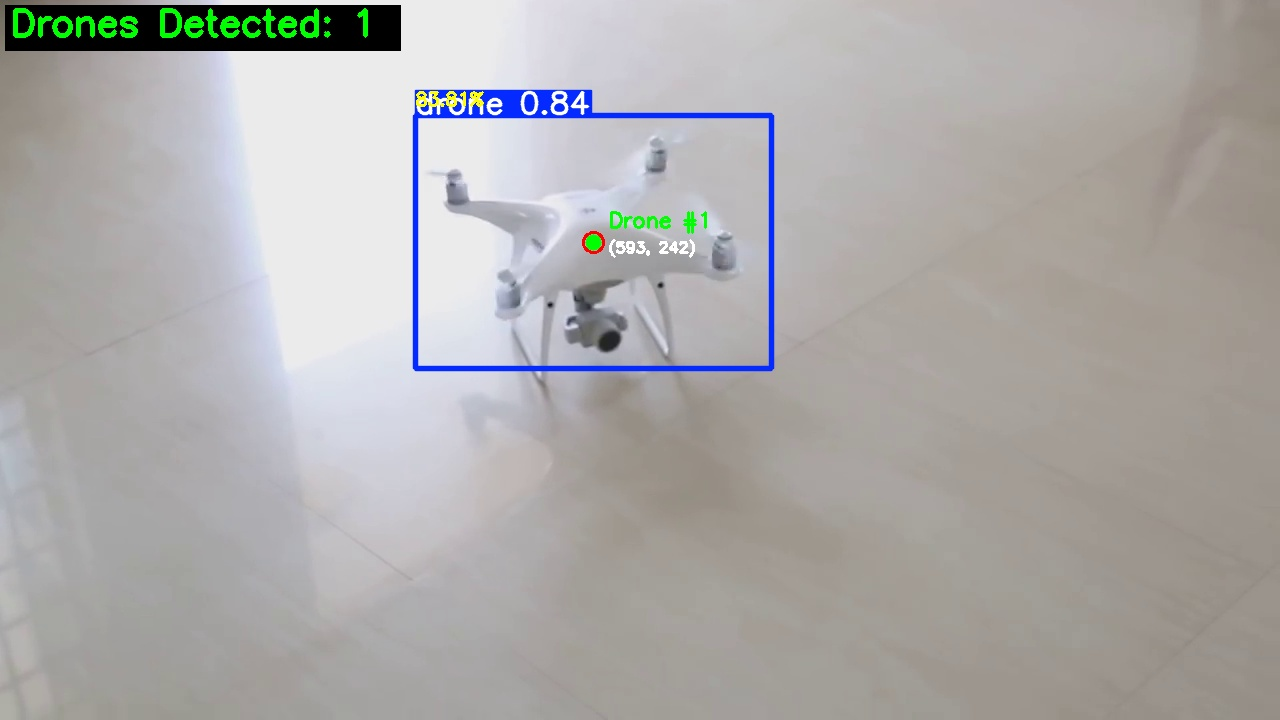

(1,
 [{'id': 1,
   'class': 0,
   'center': (593, 242),
   'bbox': (415, 115, 771, 368),
   'confidence': 0.838058590888977,
   'width': 356,
   'height': 252,
   'area': 90041}])

In [ ]:
detect_drones_image(f'{base_path}/valid/images/foto05656.jpg', 'result1.jpg')

In [ ]:
def detect_drones_video(video_path, output_path='output_video.mp4', conf=0.5):
    """
    ตรวจจับ drone ในวิดีโอ

    Args:
        video_path: path ของวิดีโอ
        output_path: path สำหรับบันทึกวิดีโอผลลัพธ์
        conf: confidence threshold

    Returns:
        output_path: path ของวิดีโอที่บันทึก
    """
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"can't open thi video: {video_path}")
        return None

    # video info
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"\nVideo info:")
    print(f"  FPS: {fps}")
    print(f"  frame size: {width}x{height}")
    print(f"  frame num: {total_frames}")

    # create VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0
    drone_count_per_frame = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Predict
        results = model(frame, conf=conf, verbose=False)

        # draw bounding box
        annotated = results[0].plot()

        # find drone centroid
        boxes = results[0].boxes
        num_drones = len(boxes)
        drone_count_per_frame.append(num_drones)

        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            center_x = int((x1 + x2) / 2)
            center_y = int((y1 + y2) / 2)

            # draw centroid
            cv2.circle(annotated, (center_x, center_y), 8, (0, 255, 0), -1)
            cv2.circle(annotated, (center_x, center_y), 10, (0, 0, 255), 2)

            # put drone ID
            cv2.putText(annotated, f"#{i+1}", (center_x+15, center_y),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # show text info in video
        info_text = [
            f"Frame: {frame_count + 1}/{total_frames}",
            f"Drones: {num_drones}",
        ]

        y_offset = 30
        for text in info_text:
            cv2.putText(annotated, text, (10, y_offset),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            y_offset += 40

        # put frame count text
        out.write(annotated)
        frame_count += 1

        # show progress
        if frame_count % 30 == 0 or frame_count == total_frames:
            progress = (frame_count / total_frames) * 100
            print(f"  progress: {frame_count}/{total_frames} frames ({progress:.1f}%)")

    cap.release()
    out.release()

    # summary
    avg_drones = sum(drone_count_per_frame) / len(drone_count_per_frame) if drone_count_per_frame else 0
    max_drones = max(drone_count_per_frame) if drone_count_per_frame else 0

    print(f"\nVideo processing complete")
    print(f"  saved at: {output_path}")
    print(f"  drone avg: {avg_drones:.2f} per frame")
    print(f"  max drone: {max_drones} per frame")

    return output_path


In [ ]:
detect_drones_video('/content/12625471_1440_2560_30fps.mp4', 'output_video.mp4')


Video info:
  FPS: 29
  frame size: 1440x2560
  frame num: 356
  progress: 30/356 frames (8.4%)
  progress: 60/356 frames (16.9%)
  progress: 90/356 frames (25.3%)
  progress: 120/356 frames (33.7%)
  progress: 150/356 frames (42.1%)
  progress: 180/356 frames (50.6%)
  progress: 210/356 frames (59.0%)
  progress: 240/356 frames (67.4%)
  progress: 270/356 frames (75.8%)
  progress: 300/356 frames (84.3%)
  progress: 330/356 frames (92.7%)
  progress: 356/356 frames (100.0%)

Video processing complete
  saved at: output_video.mp4
  drone avg: 1.61 per frame
  max drone: 3 per frame


'output_video.mp4'